In [1]:
import torch
print(torch.cuda.is_available())  # CUDA 사용 가능 여부 확인

False


In [5]:
import os
HOME = os.getcwd()
print(HOME)

c:\Users\user\Desktop\small object dataset


## YOLOv10 설치
YOLOv10 공식 깃허브 페이지로부터 다운로드 받는 부분입니다.

In [5]:
%cd "{HOME}"
!git clone https://github.com/THU-MIG/yolov10.git

c:\Users\user\Desktop\small object dataset


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
Cloning into 'yolov10'...


**NOTE:** yolov10 내부 코드를 수정 시 재설치 필요 없이 즉시 변경사항이 반영되도록 개발 모드로 설치

In [ ]:
# yolov10 패키지 개발 모드로 설치: 수정 즉시 반영
%cd "{HOME}/yolov10"
%pip install -e .

c:\Users\user\Desktop\small object dataset\yolov10
Obtaining file:///C:/Users/user/Desktop/small%20object%20dataset/yolov10
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for ultralytics (pyproject.toml): started
  Building editable for ultralytics (pyproject.toml): finished with status 'done'
  Created wheel for ultralytics: filename=ultralytics-8.1.34-0.editable-py3-none-any.whl size=20808 sha256=e8edf20989a0881d6c1b21f94090c342a97d0a840fe1418df0868a02331a2004
  Stored in directory: C:\Users\user\AppData\Local\Temp\pip-ephe

DEPRECATION: Loading egg at c:\python312\lib\site-packages\affine-3.0b1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\python312\lib\site-packages\attrs-25.1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\python312\lib\site-packages\click-8.1.8-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\python312\lib\site-packages\click_plugins-1.1.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to 

## Download pre-trained weights

**NOTE:** Yolov10 에서 제공하는 사전 학습된 가중치 파일들을 다운로드

In [11]:
import os
import requests

# weights 디렉토리 생성
os.makedirs(f"{HOME}/weights", exist_ok=True)

# YOLOv10 모델 가중치 파일 리스트
weights = [
    "yolov10n.pt", "yolov10s.pt", "yolov10m.pt",
    "yolov10b.pt", "yolov10x.pt", "yolov10l.pt"
]

# 파일 다운로드 함수
def download_file(url, save_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"✅ 다운로드 완료: {save_path}")
    else:
        print(f"❌ 다운로드 실패: {url}")

# YOLOv10 가중치 다운로드
for weight in weights:
    url = f"https://github.com/THU-MIG/yolov10/releases/download/v1.1/{weight}"
    save_path = os.path.join(HOME, "weights", weight)
    download_file(url, save_path)

# 다운로드된 파일 확인
print("\n✅ 다운로드된 파일 목록:")
print(os.listdir(f"{HOME}/weights"))

✅ 다운로드 완료: c:\Users\user\Desktop\small object dataset\weights\yolov10n.pt
✅ 다운로드 완료: c:\Users\user\Desktop\small object dataset\weights\yolov10s.pt
✅ 다운로드 완료: c:\Users\user\Desktop\small object dataset\weights\yolov10m.pt
✅ 다운로드 완료: c:\Users\user\Desktop\small object dataset\weights\yolov10b.pt
✅ 다운로드 완료: c:\Users\user\Desktop\small object dataset\weights\yolov10x.pt
✅ 다운로드 완료: c:\Users\user\Desktop\small object dataset\weights\yolov10l.pt

✅ 다운로드된 파일 목록:
['yolov10b.pt', 'yolov10l.pt', 'yolov10m.pt', 'yolov10n.pt', 'yolov10s.pt', 'yolov10x.pt']


## Custom Training

NWPU_VHR10 데이터셋의 경우 train, val 구분이 없기 때문에 임의로 8:2로 생성 <BR>
이미 분할되어 있는 데이터 셋의 경우 이 과정 불필요

In [37]:
import os
import shutil
import random

# 데이터 경로 설정
data_path = f"{HOME}/data/NWPU_VHR10_YOLO"   #데이터 경로는 본인의 환경에 맞게 수정
image_dir = os.path.join(data_path, "images")
label_dir = os.path.join(data_path, "labels")

# 디렉터리 생성
os.makedirs(f"{image_dir}/train", exist_ok=True)
os.makedirs(f"{image_dir}/val", exist_ok=True)
os.makedirs(f"{label_dir}/train", exist_ok=True)
os.makedirs(f"{label_dir}/val", exist_ok=True)

# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# 파일 섞기
random.seed(42)
random.shuffle(image_files)

# 8:2로 분할
train_count = int(len(image_files) * 0.8)
train_files = image_files[:train_count]
val_files = image_files[train_count:]

# 파일 이동
for split, files in [('train', train_files), ('val', val_files)]:
    for file in files:
        src_img = os.path.join(image_dir, file)
        dst_img = os.path.join(image_dir, split, file)

        label_file = file.replace('.png', '.txt')
        src_label = os.path.join(label_dir, label_file)
        dst_label = os.path.join(label_dir, split, label_file)

        shutil.move(src_img, dst_img)
        if os.path.exists(src_label):
            shutil.move(src_label, dst_label)

print("Dataset split 완료!")

Dataset split 완료!


data.yaml 파일은 각 데이터셋에 맞게끔 수정

In [ ]:
# data.yaml 파일 내용
data_yaml = f"""
train: {data_path}/images/train
val: {data_path}/images/val

nc: 10
names: ['airplane', 'ship', 'storage tank', 'baseball diamond',
        'tennis court', 'basketball court', 'ground track field',
        'harbor', 'bridge', 'vehicle']
"""

# data.yaml 파일 생성 및 저장
with open(os.path.join(data_path, 'data.yaml'), 'w') as f:
    f.write(data_yaml)

print(data_yaml)



train: c:\Users\user\Desktop\small object dataset/data/NWPU_VHR10_YOLO/images/train
val: c:\Users\user\Desktop\small object dataset/data/NWPU_VHR10_YOLO/images/val

nc: 10
names: ['airplane', 'ship', 'storage tank', 'baseball diamond',
        'tennis court', 'basketball court', 'ground track field',
        'harbor', 'bridge', 'vehicle']



In [22]:
%cd {HOME}

# YOLOv10 학습 실행
# 하이퍼 파라미터는 자유롭게 튜닝
!yolo task=detect mode=train epochs=10 batch=16 plots=True \
model="{HOME}/weights/yolov10n.pt" \
data="{HOME}/data/NWPU_VHR10_YOLO/data.yaml" \
project="YOLOv10-Experiment" \
name="NWPU-VHR10-Run"

c:\Users\user\Desktop\small object dataset
Ultralytics 8.3.86 🚀 Python-3.12.2 torch-2.6.0+cpu CPU (12th Gen Intel Core(TM) i5-12600)
engine\trainer: task=detect, mode=train, model=c:\Users\user\Desktop\small object dataset/weights/yolov10n.pt, data=c:\Users\user\Desktop\small object dataset/data/NWPU_VHR10_YOLO/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=YOLOv10-Experiment, name=NWPU-VHR10-Run, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False


train: Scanning C:\Users\user\Desktop\small object dataset\data\NWPU_VHR10_YOLO\labels\train.cache... 520 images, 0 backgrounds, 0 corrupt: 100%|██████████| 520/520 [00:00<?, ?it/s]
train: Scanning C:\Users\user\Desktop\small object dataset\data\NWPU_VHR10_YOLO\labels\train.cache... 520 images, 0 backgrounds, 0 corrupt: 100%|██████████| 520/520 [00:00<?, ?it/s]

val: Scanning C:\Users\user\Desktop\small object dataset\data\NWPU_VHR10_YOLO\labels\val.cache... 130 images, 0 backgrounds, 0 corrupt: 100%|██████████| 130/130 [00:00<?, ?it/s]
val: Scanning C:\Users\user\Desktop\small object dataset\data\NWPU_VHR10_YOLO\labels\val.cache... 130 images, 0 backgrounds, 0 corrupt: 100%|██████████| 130/130 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]
       1/10         0G      3.056      11.03      2.493         81        640:   0%|          | 0/33 [00:11<?, ?it/s]
       1/10         0G      3.056      11.03      2.493         81        640:   3%|▎         | 1/33 [00:11<06:03, 11.37

In [28]:
project="YOLOv10-Experiment"
name="NWPU-VHR10-Run"


%ls "{HOME}/{project}/{name}"

 C ����̺��� �������� �̸��� �����ϴ�.
 ���� �Ϸ� ��ȣ: 7A35-65CA

 c:\Users\user\Desktop\small object dataset\YOLOv10-Experiment\NWPU-VHR10-Run ���͸�

2025-03-10  ���� 09:10    <DIR>          .
2025-03-10  ���� 08:37    <DIR>          ..
2025-03-10  ���� 08:37             1,787 args.yaml
2025-03-10  ���� 09:10           184,609 confusion_matrix.png
2025-03-10  ���� 09:10           208,816 confusion_matrix_normalized.png
2025-03-10  ���� 09:10           416,974 F1_curve.png
2025-03-10  ���� 08:38           181,215 labels.jpg
2025-03-10  ���� 08:38           224,985 labels_correlogram.jpg
2025-03-10  ���� 09:10           349,646 P_curve.png
2025-03-10  ���� 09:10           226,782 PR_curve.png
2025-03-10  ���� 09:10           346,160 R_curve.png
2025-03-10  ���� 09:09             1,447 results.csv
2025-03-10  ���� 09:10           254,107 results.png
2025-03-10  ���� 08:38           467,834 train_batch0.jpg
2025-03-10  ���� 08:38           487,536 train_batch1.jpg
2025-03-10  ���� 08:38      

c:\Users\user\Desktop\small object dataset


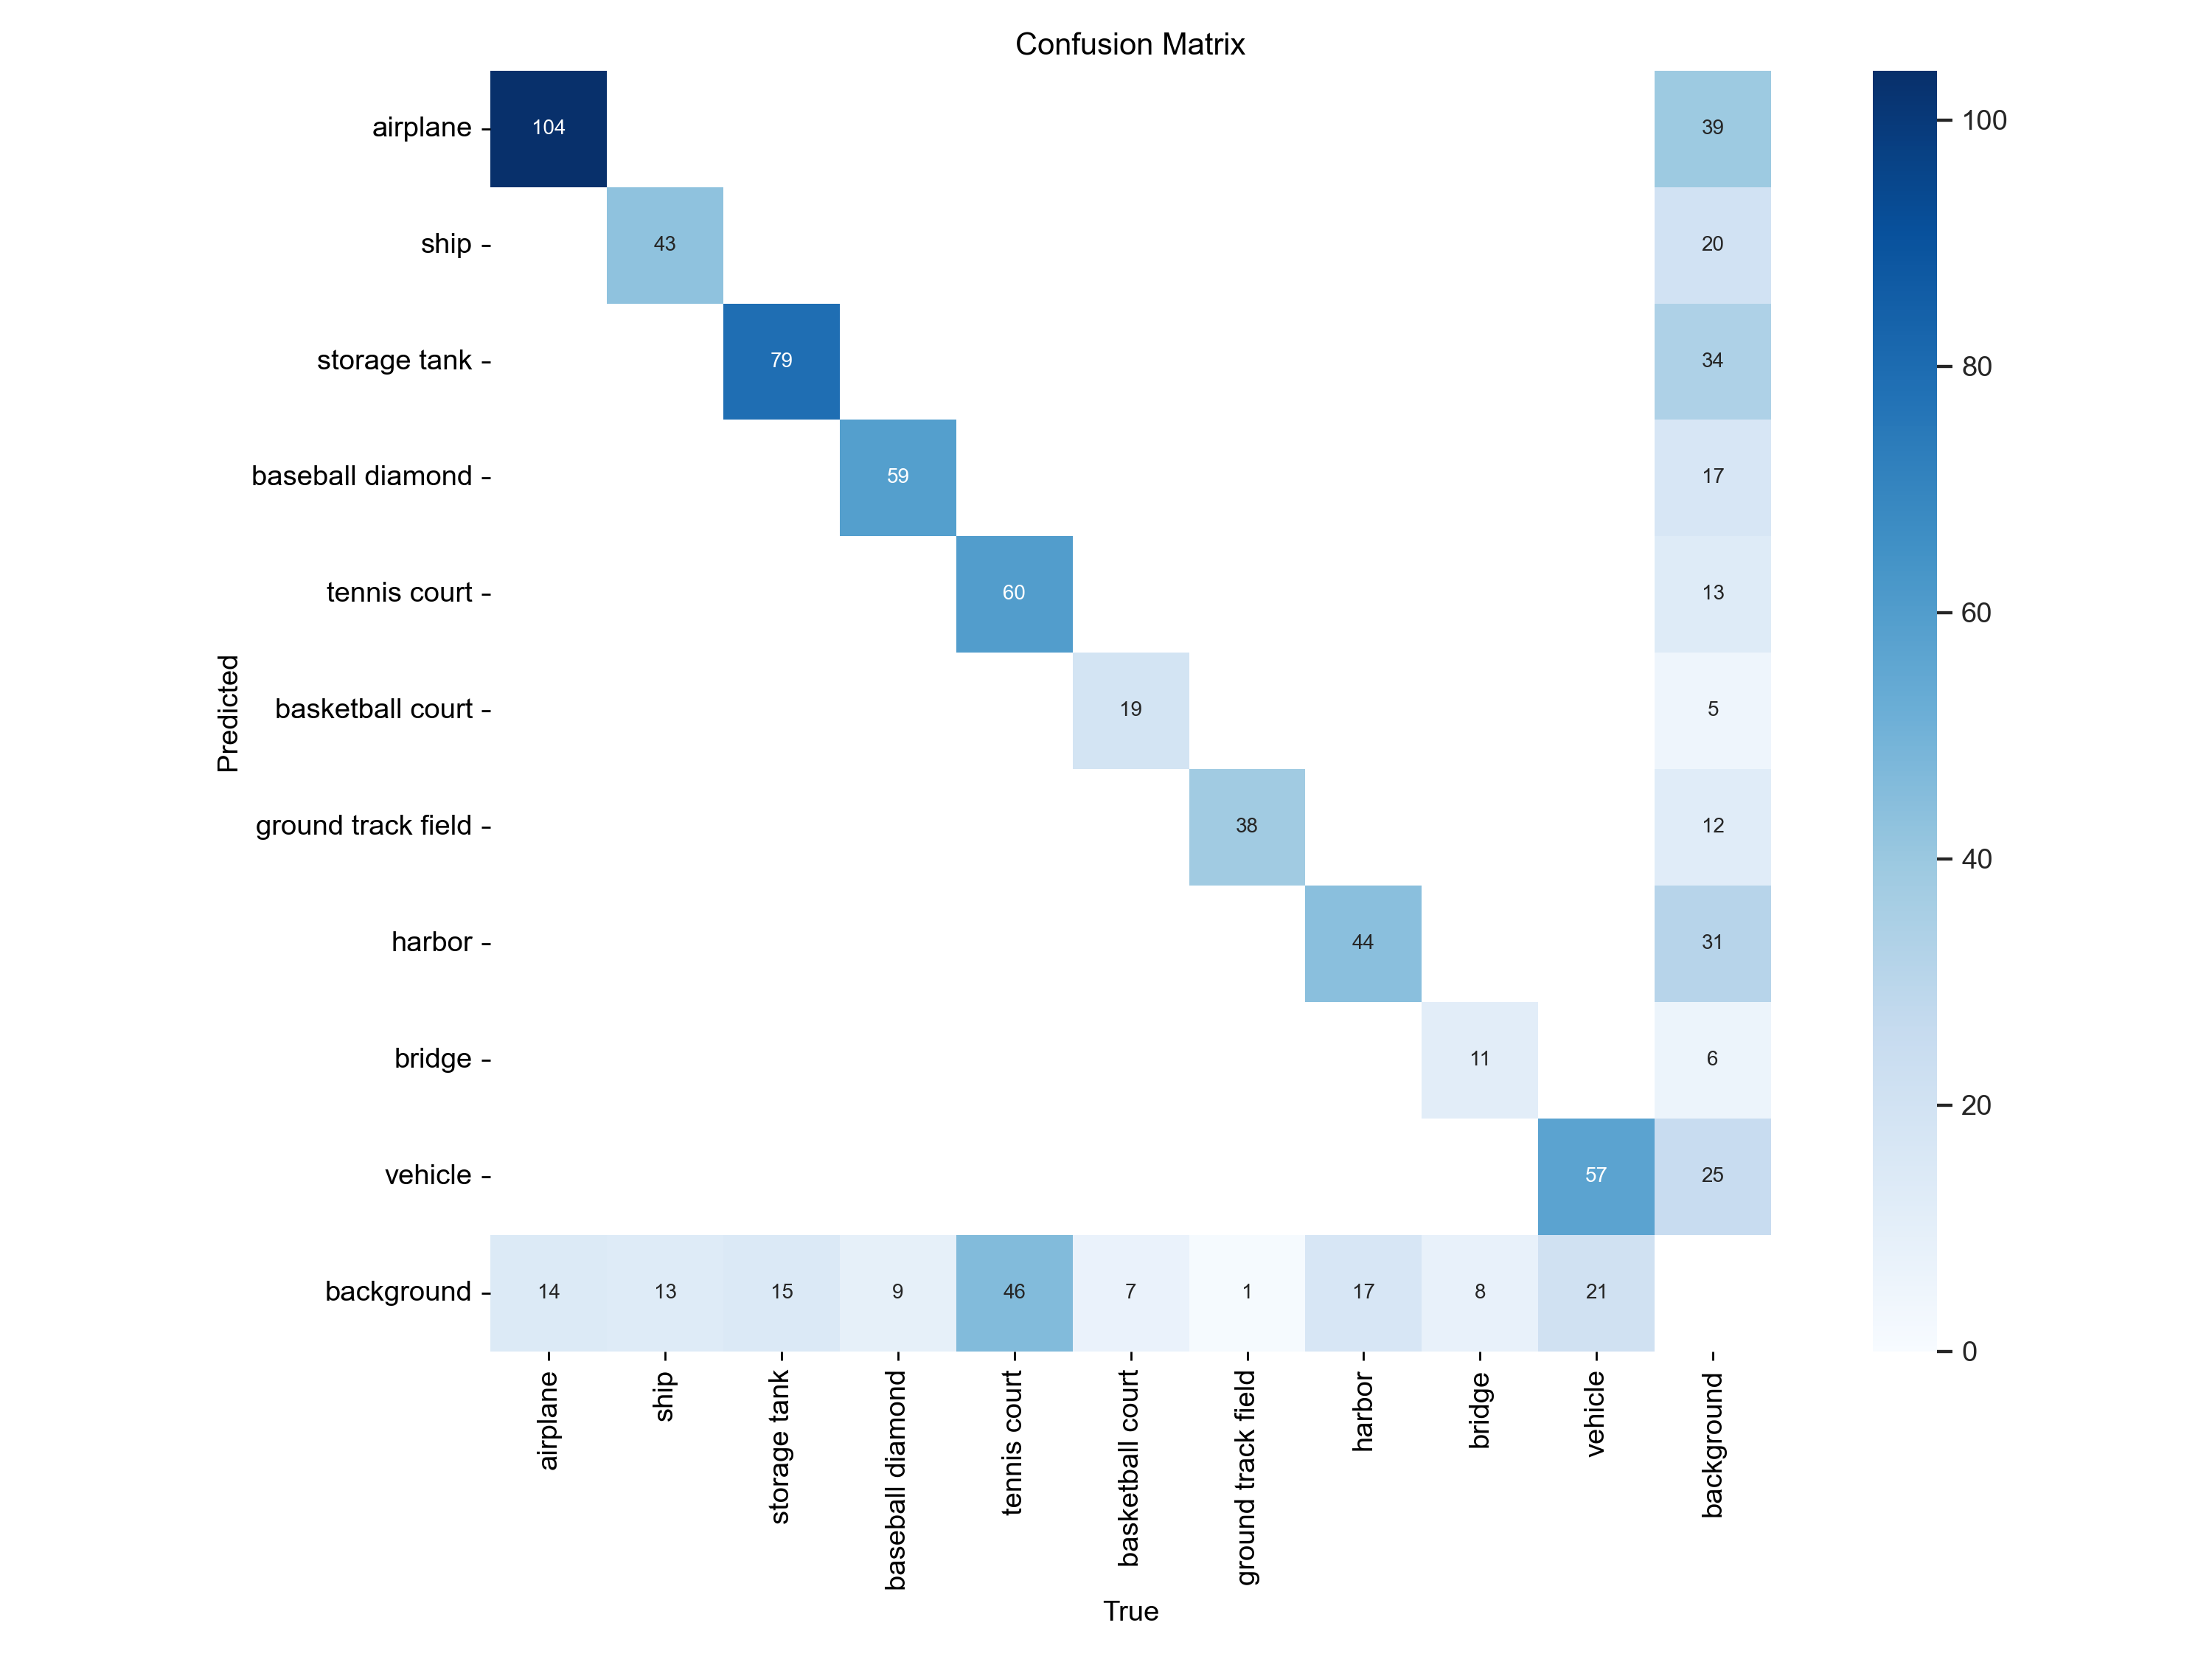

In [23]:
from IPython.display import Image

%cd {HOME}
Image(filename=f'{HOME}/{project}/{name}/confusion_matrix.png', width=600)

c:\Users\user\Desktop\small object dataset


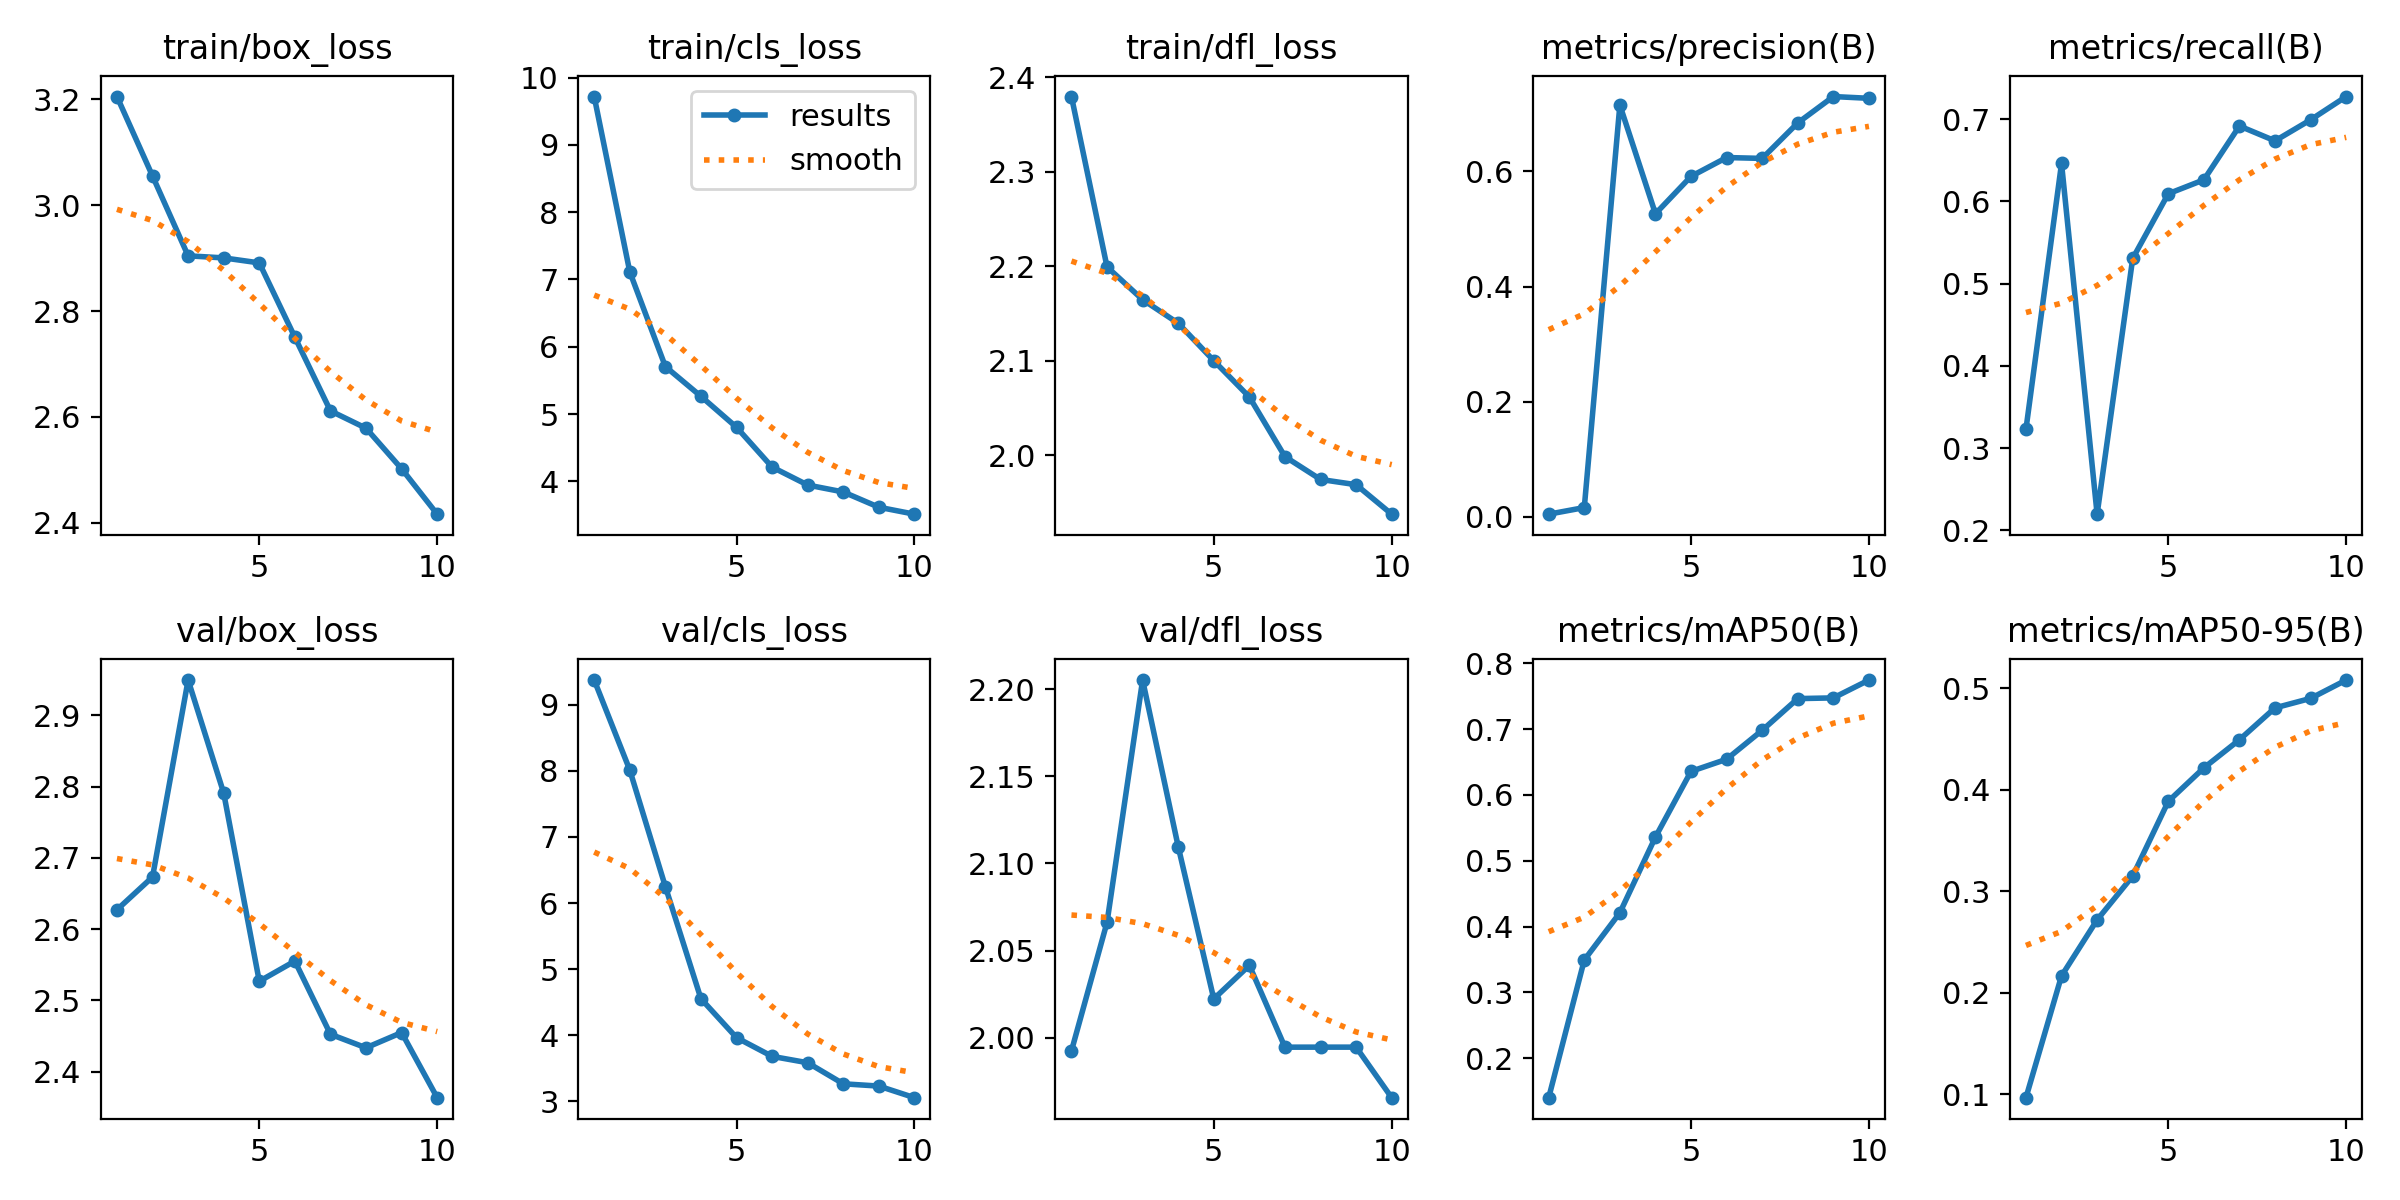

In [25]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name}/results.png', width=600)

## Inference with Custom Model

새로 학습한 모델을 추론

In [26]:
from ultralytics import YOLO
import supervision as sv

# best.pt 모델 로드
model = YOLO(f'{HOME}/{project}/{name}/weights/best.pt')
data_path = f"{HOME}/data/NWPU_VHR10_YOLO"

# Supervision을 활용한 데이터셋 로드드
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{data_path}/images/val",
    annotations_directory_path=f"{data_path}/labels/val",
    data_yaml_path=f"{data_path}/data.yaml"
)

# 바운딩 박스 & 라벨 시각화
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Validation set 에서 랜덤하게 이미지를 가져다가 시각화

선택된 이미지 파일: c:\Users\user\Desktop\small object dataset\data\NWPU_VHR10_YOLO\images\val\409.png

0: 640x544 9 vehicles, 74.3ms
Speed: 9.5ms preprocess, 74.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 544)


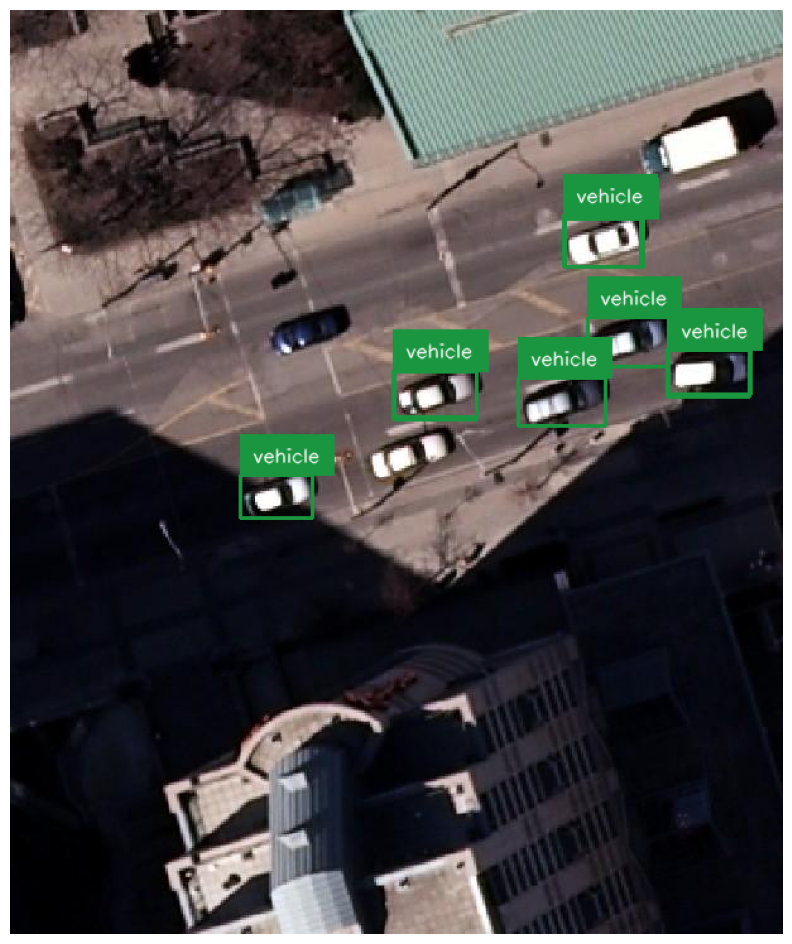

In [27]:
import random

# 랜덤으로 하나의 이미지 경로를 선택
random_image_path, random_image, annotation = random.choice(list(dataset))

print(f"선택된 이미지 파일: {random_image_path}")

results_list = model.predict(source=random_image, conf=0.25)  # 모델 추론 수행
if results_list:  # 결과가 있을 경우만 진행
    results = results_list[0]  # 리스트에서 첫 번째 결과 선택

    # === 탐지 결과를 supervision 형식으로 변환 ===
    detections = sv.Detections.from_ultralytics(results)

    # === Bounding Box 및 Label 추가 ===
    annotated_image = bounding_box_annotator.annotate(scene=random_image.copy(), detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # === 최종 결과 시각화 ===
    sv.plot_image(annotated_image)
else:
    print("⚠️ Warning: YOLOv10 모델이 객체를 탐지하지 못했습니다.")